In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression

In [5]:
import os
from os.path import curdir
csv_path = os.path.join(curdir,'Cleand_food_price_dataset.csv')

In [6]:
df = pd.read_csv(csv_path, header='infer')
df.head()

,REF_DATE,GEO,Products,UOM,VALUE,Avg_CPI,Avg_CPI_Gas,day,month,year,ProductsUOM,Meat_Category
0,2017-01-01,Canada,Beef stewing cuts,Dollars,12.66,1.8,161.7,1,1,2017,per kilogram,Beef
1,2017-01-01,Canada,Beef striploin cuts,Dollars,21.94,1.8,161.7,1,1,2017,per kilogram,Beef
2,2017-01-01,Canada,Beef top sirloin cuts,Dollars,13.44,1.8,161.7,1,1,2017,per kilogram,Beef
3,2017-01-01,Canada,Beef rib cuts,Dollars,20.17,1.8,161.7,1,1,2017,per kilogram,Beef
4,2017-01-01,Canada,Ground beef,Dollars,9.12,1.8,161.7,1,1,2017,per kilogram,Beef


In [7]:
df.tail()

,REF_DATE,GEO,Products,UOM,VALUE,Avg_CPI,Avg_CPI_Gas,day,month,year,ProductsUOM,Meat_Category
10434,2023-01-01,British Columbia,Whole chicken,Dollars,7.90,5.1,218.1,1,1,2023,per kilogram,Chicken
10435,2023-01-01,British Columbia,Chicken breasts,Dollars,16.33,5.1,218.1,1,1,2023,per kilogram,Chicken
10436,2023-01-01,British Columbia,Chicken thigh,Dollars,12.33,5.1,218.1,1,1,2023,per kilogram,Chicken
10437,2023-01-01,British Columbia,Chicken drumsticks,Dollars,9.03,5.1,218.1,1,1,2023,per kilogram,Chicken
10438,2023-01-01,British Columbia,Bacon,Dollars,7.27,5.1,218.1,1,1,2023,500 grams,Bacon


In [8]:
df2 = df.loc[df['Meat_Category'] != "Bacon" ]

In [9]:
df2.head()

,REF_DATE,GEO,Products,UOM,VALUE,Avg_CPI,Avg_CPI_Gas,day,month,year,ProductsUOM,Meat_Category
0,2017-01-01,Canada,Beef stewing cuts,Dollars,12.66,1.8,161.7,1,1,2017,per kilogram,Beef
1,2017-01-01,Canada,Beef striploin cuts,Dollars,21.94,1.8,161.7,1,1,2017,per kilogram,Beef
2,2017-01-01,Canada,Beef top sirloin cuts,Dollars,13.44,1.8,161.7,1,1,2017,per kilogram,Beef
3,2017-01-01,Canada,Beef rib cuts,Dollars,20.17,1.8,161.7,1,1,2017,per kilogram,Beef
4,2017-01-01,Canada,Ground beef,Dollars,9.12,1.8,161.7,1,1,2017,per kilogram,Beef


In [10]:
# only focus on Geo = 'Canada' when predicting price for 2023
df2_Canada = df2.loc[df2['GEO'] == "Canada"]

In [11]:
# average price group by meat_value and aggregate by year, month, day, Avg_CPI and Avg_CPI_Gas
groupByResult = df2_Canada.groupby(['Meat_Category', 'year', 'month', 'day']).agg({
    'VALUE': 'mean',
    'Avg_CPI': 'first',
    'Avg_CPI_Gas': 'first'
}).reset_index()
df3 = groupByResult
df3

,Meat_Category,year,month,day,VALUE,Avg_CPI,Avg_CPI_Gas
0,Beef,2017,1,1,15.466000,1.8,161.7
1,Beef,2017,2,1,15.608000,1.8,153.7
2,Beef,2017,3,1,16.598000,1.7,152.0
3,Beef,2017,4,1,14.508000,1.6,166.5
4,Beef,2017,5,1,16.460000,1.6,159.8
...,...,...,...,...,...,...,...
214,Pork,2022,9,1,8.720000,5.1,227.6
215,Pork,2022,10,1,8.123333,5.3,248.6
216,Pork,2022,11,1,8.046667,5.3,239.6
217,Pork,2022,12,1,8.496667,5.2,208.3


In [12]:
mapping_meat = {item:i for i, item in enumerate(df3['Meat_Category'].unique(),1)}
df3["Num_Meat"] = df3['Meat_Category'].apply(lambda x: mapping_meat[x])
df3

,Meat_Category,year,month,day,VALUE,Avg_CPI,Avg_CPI_Gas,Num_Meat
0,Beef,2017,1,1,15.466000,1.8,161.7,1
1,Beef,2017,2,1,15.608000,1.8,153.7,1
2,Beef,2017,3,1,16.598000,1.7,152.0,1
3,Beef,2017,4,1,14.508000,1.6,166.5,1
4,Beef,2017,5,1,16.460000,1.6,159.8,1
...,...,...,...,...,...,...,...,...
214,Pork,2022,9,1,8.720000,5.1,227.6,3
215,Pork,2022,10,1,8.123333,5.3,248.6,3
216,Pork,2022,11,1,8.046667,5.3,239.6,3
217,Pork,2022,12,1,8.496667,5.2,208.3,3


In [13]:
frmla = 'VALUE ~ Avg_CPI + Avg_CPI_Gas + month + year + Num_Meat'

In [14]:
from statsmodels.formula.api import ols
model = ols(frmla,df3).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  VALUE   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     147.2
Date:                Mon, 24 Apr 2023   Prob (F-statistic):           4.61e-67
Time:                        20:29:39   Log-Likelihood:                -471.35
No. Observations:                 219   AIC:                             954.7
Df Residuals:                     213   BIC:                             975.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -719.3229    284.856     -2.525      

In [15]:
#Import the required package from sklearn
from sklearn.linear_model import LinearRegression

'''
In order to input data from a pandas dataframe and into a sci-kit function,
we need to convert the dataframe series into NumPy Arrays. This can be done
with the values function.
'''
train_X = df3[['Avg_CPI', 'Avg_CPI_Gas', 'month', 'year', 'Num_Meat']].values
train_y = df3['VALUE'].values

'''
Fitting data to a regression model requires two arguments, the training X
values (independent variables) and the training y values (dependent variables.
In general, most fit functions for models follow this format.
'''
reg = LinearRegression().fit(train_X, train_y)

Residuals vs Fitted Values

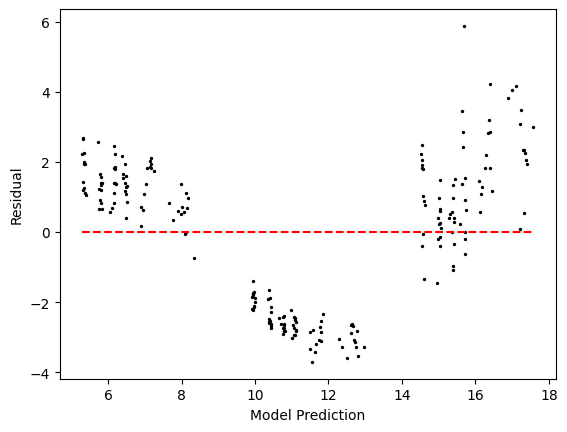

In [16]:
#Residuals calculated by definition above.
predicted_y = reg.predict(train_X)
#Note we can perform element-wise subtraction between arrays like so
residuals = train_y - predicted_y

import matplotlib.pyplot as plt
plt.scatter(predicted_y,residuals,s=2,c='black')

#This line adds the dashed horizontal line
plt.hlines(0,min(predicted_y),max(predicted_y),color='red',linestyles='dashed')

plt.xlabel("Model Prediction")
plt.ylabel("Residual")
plt.show()

Normal Q-Q

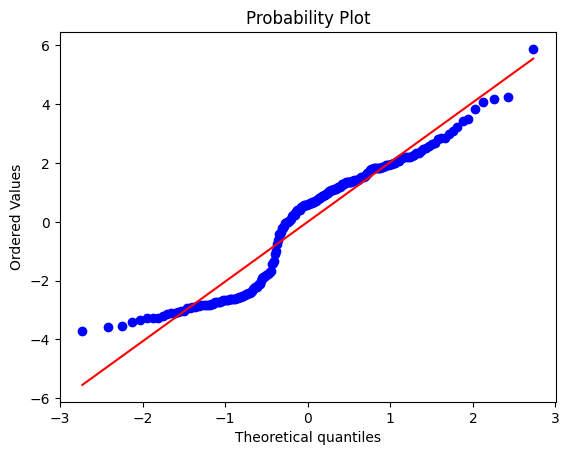

In [17]:
import scipy.stats as stats

'''
Boilerplate code for creating a Normal Q-Q plot. The first two lines declare 
a figure and a subplot. This is an alternate way to output plots which allows 
for more than one plot per output.
'''
fig = plt.figure()
ax = fig.add_subplot(111)

'''
Scipy.Stats has a built-in function for generating this type of plot. This 
function takes three arguments: the measurement being checked (residuals), 
the distribution we are checking against (normal in this case), and the plot 
to plot it to.
'''
stats.probplot(residuals,dist='norm',plot=ax)
plt.show()

Scale-Location

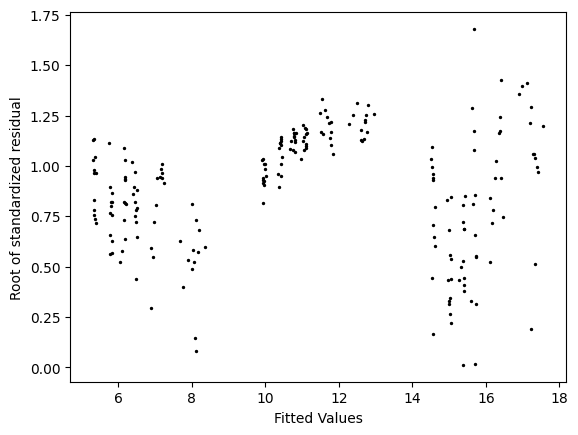

In [18]:
from sklearn.preprocessing import StandardScaler

# First we create an array of normalized residuals using a Scikit function
scaler = StandardScaler().fit(residuals.reshape(-1,1))
norm_residuals = scaler.transform(residuals.reshape(-1,1))

# Plot and take the root and absolute values of the norms
plt.scatter(predicted_y,np.sqrt(np.abs(norm_residuals)),c='black',s=2)
plt.xlabel("Fitted Values")
plt.ylabel("Root of standardized residual")
plt.show()

Density Plot

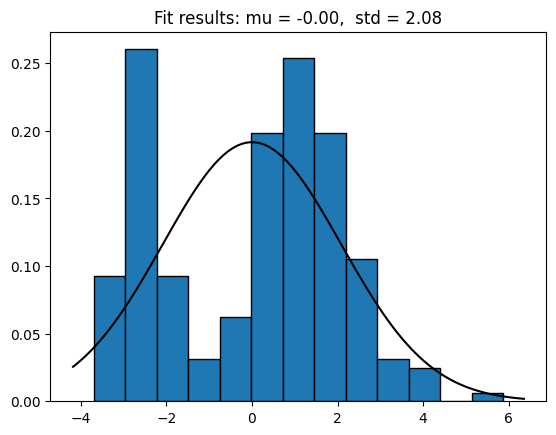

In [19]:
from scipy.stats import norm

# Fit a normal distribution to the data:
mean, std = norm.fit(residuals)

# Plot the histogram.
plt.hist(residuals, bins=13, edgecolor='black', density=True)

# Generate a PDF based on the fitted distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, color='black')
title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)

plt.show()

Residuals vs. Leverage

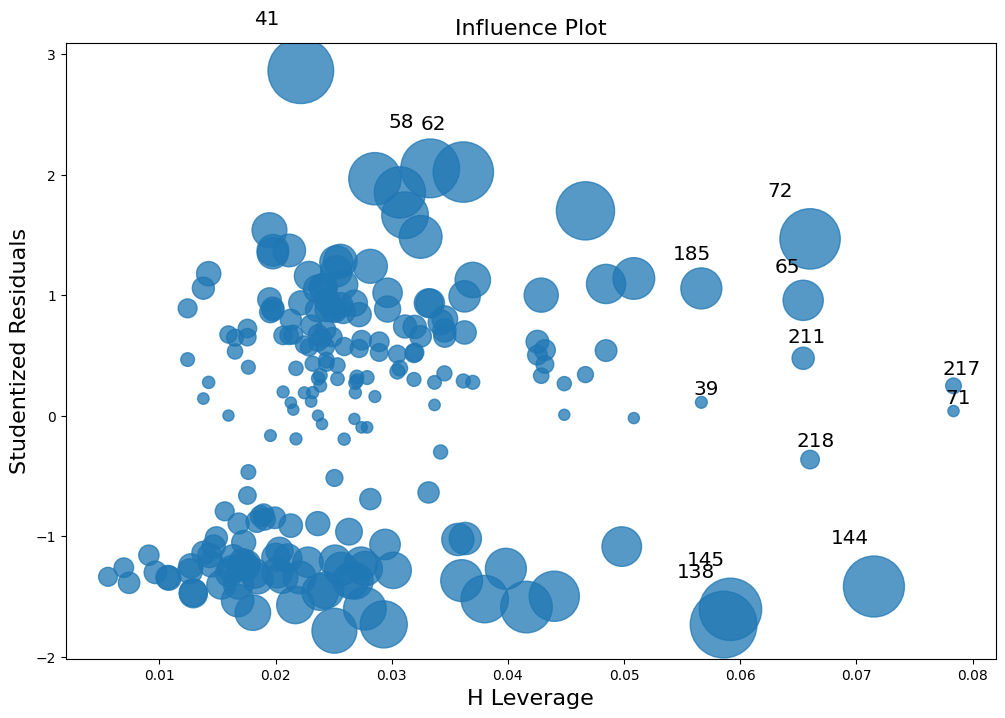

In [20]:
#In a similar fashion to how the QQ plot was built, this plot can be generated.
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
plt.show()